<div class="alert alert-block alert-success">
    <h1 align="center">Machine Learning in Python</h1>
    <h3 align="center">Project2</h3>
            <h4 align="center"><a href="https://www.linkedin.com/public-profile/settings?trk=d_flagship3_profile_self_view_public_profile&lipi=urn%3Ali%3Apage%3Ad_flagship3_profile_self_edit_top_card%3BhFw1W2M%2FTMCAYZp6pzKt1Q%3D%3D">Seyed Mohammad Sajadi</a></h4>
</div>

<img src = "https://slitayem.github.io/img/blog/2020-08-04/churn.png" width=50%>

## Importing the libraries

In [1]:
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

import numpy as np
import pandas as pd
pd.set_option('precision', 3)
pd.options.mode.chained_assignment = None

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('darkgrid')

from scipy.stats import chi2_contingency
from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, learning_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# import scikitplot as skplt

label_size = 17

plt.rcParams['axes.labelsize'] = label_size
plt.rcParams['xtick.labelsize'] = label_size - 2
plt.rcParams['ytick.labelsize'] = label_size - 2
plt.rcParams['axes.titlesize'] = label_size
plt.rcParams['legend.fontsize'] = label_size - 2

random_state = 42
scoring_metric = 'recall'
comparison_dict = {}
comparison_test_dict = {}

print ('Libraries Loaded!')

Libraries Loaded!


## Load and Prepare Data

In [2]:
df = pd.read_csv('Churn.csv')

print ('This dataset contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))
df.head()

This dataset contains 10000 rows and 14 columns.


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## EDA

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [4]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis = 1, inplace = True)
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.529,96.653,350.00,584.00,652.000,718.000,850.00
Age,10000.0,38.922,10.488,18.00,32.00,37.000,44.000,92.00
Tenure,10000.0,5.013,2.892,0.00,3.00,5.000,7.000,10.00
Balance,10000.0,76485.889,62397.405,0.00,0.00,97198.540,127644.240,250898.09
NumOfProducts,10000.0,1.530,0.582,1.00,1.00,1.000,2.000,4.00
HasCrCard,10000.0,0.706,0.456,0.00,0.00,1.000,1.000,1.00
IsActiveMember,10000.0,0.515,0.500,0.00,0.00,1.000,1.000,1.00
EstimatedSalary,10000.0,100090.240,57510.493,11.58,51002.11,100193.915,149388.247,199992.48
Exited,10000.0,0.204,0.403,0.00,0.00,0.000,0.000,1.00


## Data Preprocessing

In [6]:
def plot_continuous(feature):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
    
    sns.distplot(df_remained[feature], bins = 15, color = colors[0], label = 'Remained', hist_kws = dict(edgecolor = 'firebrick', linewidth = 1), ax = ax1, kde = False)
    sns.distplot(df_churned[feature], bins = 15, color = colors[1], label = 'Churned', hist_kws = dict(edgecolor = 'firebrick', linewidth = 1), ax = ax1, kde = False)
    ax1.set_title('{} distribution - Histogram'.format(feature))
    ax1.set_ylabel('Counts')
    ax1.legend()

    sns.boxplot(x = 'Exited', y = feature, data = train_df, palette = colors, ax = ax2)
    ax2.set_title('{} distribution - Box plot'.format(feature))
    ax2.set_xlabel('Status')
    ax2.set_xticklabels(['Remained', 'Churned'])

    plt.tight_layout();
    
    
def plot_categorical(feature):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 4))
    sns.countplot(x = feature, hue = 'Exited', data = train_df, palette = colors, ax = ax1)
    ax1.set_ylabel('Counts')
    ax1.legend(labels = ['Retained', 'Churned'])
    
    sns.barplot(x = feature, y = 'Exited', data = train_df, palette = colors2 , ci = None, ax = ax2)
    ax2.set_ylabel('Churn rate')
    
    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])
    
    plt.tight_layout();
    
def plot_learning_curve(estimator, estimator_name, X, y, cv = None, train_sizes = np.linspace(0.1, 1.0, 5)):
                 
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv = cv, n_jobs = -1, 
                                                            train_sizes = train_sizes, scoring = 'accuracy')
    
    train_scores_mean, train_scores_std = np.mean(train_scores, axis = 1), np.std(train_scores, axis = 1)
    test_scores_mean, test_scores_std = np.mean(test_scores, axis = 1), np.std(test_scores, axis = 1)
            
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'dodgerblue')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'darkorange')
    
    plt.plot(train_sizes, train_scores_mean, color = 'dodgerblue', marker = 'o', linestyle = '-', label = 'Training Score')
    plt.plot(train_sizes, test_scores_mean, color = 'darkorange', marker = 'o', linestyle = '-', label = 'Cross-validation Score')
    plt.title(estimator_name)
    plt.xlabel('Training Examples')
    plt.ylabel('Accuracy Score')
    plt.legend(loc = 'best')
            
    plt.tight_layout();
    
def plot_conf_mx(cm, classifier_name, ax):
    sns.heatmap(cm, annot = True, cmap = 'Blues', annot_kws = {'fontsize': 24}, ax = ax)
    ax.set_title('{}'.format(classifier_name))
    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Remained', 'Churned'])
    ax.set_ylabel('True Label') 
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Remained', 'Churned']);
    
def plot_feature_imp(classifier, classifier_name, color, ax):

    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending = True).set_index('Feature')

    importances.plot.barh(color = color, edgecolor = 'firebrick', legend = False, ax = ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');
    
def clf_performance(classifier, classifier_name, classifier_name_abv):
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items() :
        print ('      {}: {}'.format(key, value))
    
    y_pred_pp = cross_val_predict(classifier.best_estimator_, X_train, y_train, cv = 5, method = 'predict_proba')[:, 1]
    y_pred = y_pred_pp.round()
    
    cm = confusion_matrix(y_train, y_pred, normalize = 'true')
    
    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    
    comparison_dict[classifier_name_abv] = [accuracy_score(y_train, y_pred), 
                                            precision_score(y_train, y_pred),
                                            recall_score(y_train, y_pred),
                                            roc_auc_score(y_train, y_pred_pp),
                                            fpr, tpr]    

    fig, ax = plt.subplots(figsize = (5, 4))
    
    plot_conf_mx(cm, '', ax)    
    plt.tight_layout();
    
def test_func(classifier, classifier_name):
    y_pred = classifier.predict(X_test)
    cm = confusion_matrix(y_test, y_pred, normalize = 'true')
    
    comparison_test_dict[classifier_name] = [accuracy_score(y_test, y_pred), 
                                             precision_score(y_test, y_pred),
                                             recall_score(y_test, y_pred)]
    
    plt.title(classifier_name)
    sns.heatmap(cm, annot = True, annot_kws = {'fontsize': 18}, cmap = 'Blues')
    plt.xlabel('Predicted Label')
    plt.xticks([0.5, 1.5], ['Remained', 'Churned'])
    plt.ylabel('True Label') 
    plt.yticks([0.2, 1.4], ['Remained', 'Churned']);
    
print ('Functions defined!')

Functions defined!


## Strorytelling - Visualization

## Prepare Data for Machine learning

In [7]:
train_df, test_df = train_test_split(df, test_size = 0.2, random_state = 42)

train_df.reset_index(drop = True, inplace = True)
test_df.reset_index(drop = True, inplace = True)

print('Shape')
print('Train set: {} rows x {} columns'.format(train_df.shape[0], train_df.shape[1]))
print(' Test set: {} rows x {} columns'.format(test_df.shape[0], test_df.shape[1]))

Shape
Train set: 8000 rows x 11 columns
 Test set: 2000 rows x 11 columns


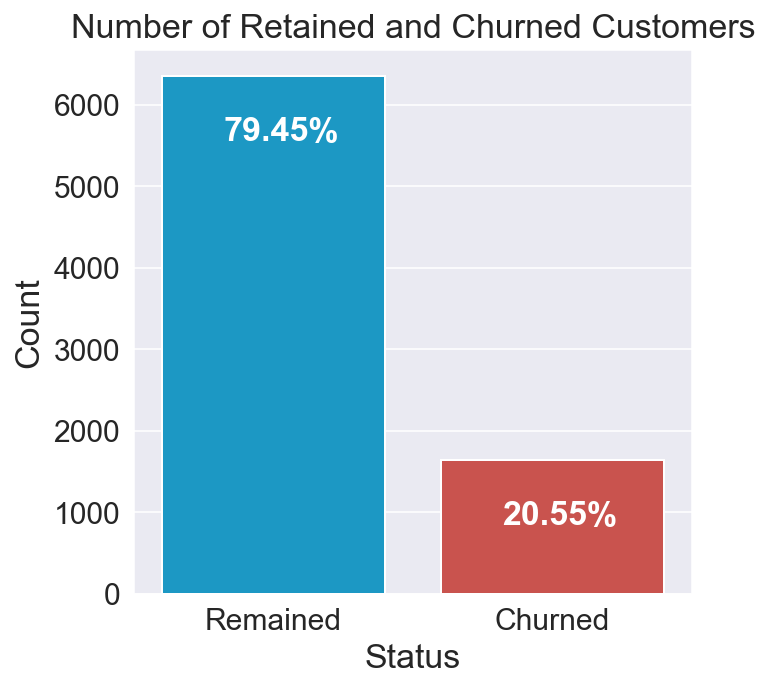

In [8]:
colors = ['#00A5E0', '#DD403A']

fig = plt.figure(figsize = (5, 5))
sns.countplot(x = 'Exited', data = train_df, palette = colors)

for index, value in enumerate(train_df['Exited'].value_counts()):
    label =  '{}%'.format(round( (value/train_df['Exited'].shape[0])*100, 2)) 
    plt.annotate(label, xy = (index - 0.18, value - 800), color = 'w', fontweight = 'bold', size = label_size)

plt.title('Number of Retained and Churned Customers')
plt.xticks([0, 1], ['Remained', 'Churned'])
plt.xlabel('Status')
plt.ylabel('Count');

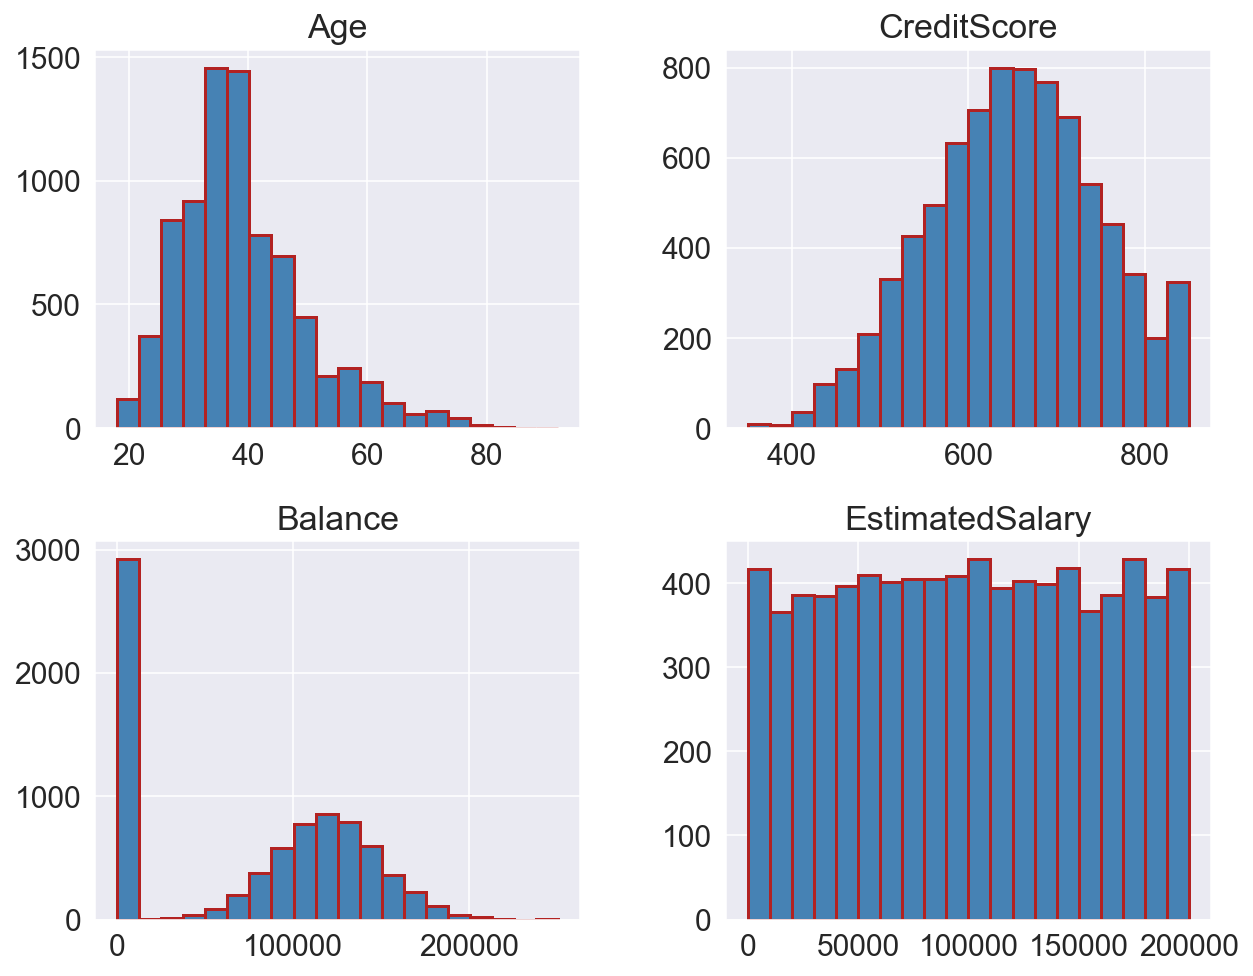

In [9]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
train_df[continuous].hist(figsize = (10, 8), bins = 20, layout = (2, 2), 
                          color = 'steelblue', edgecolor = 'firebrick', linewidth = 1.5);

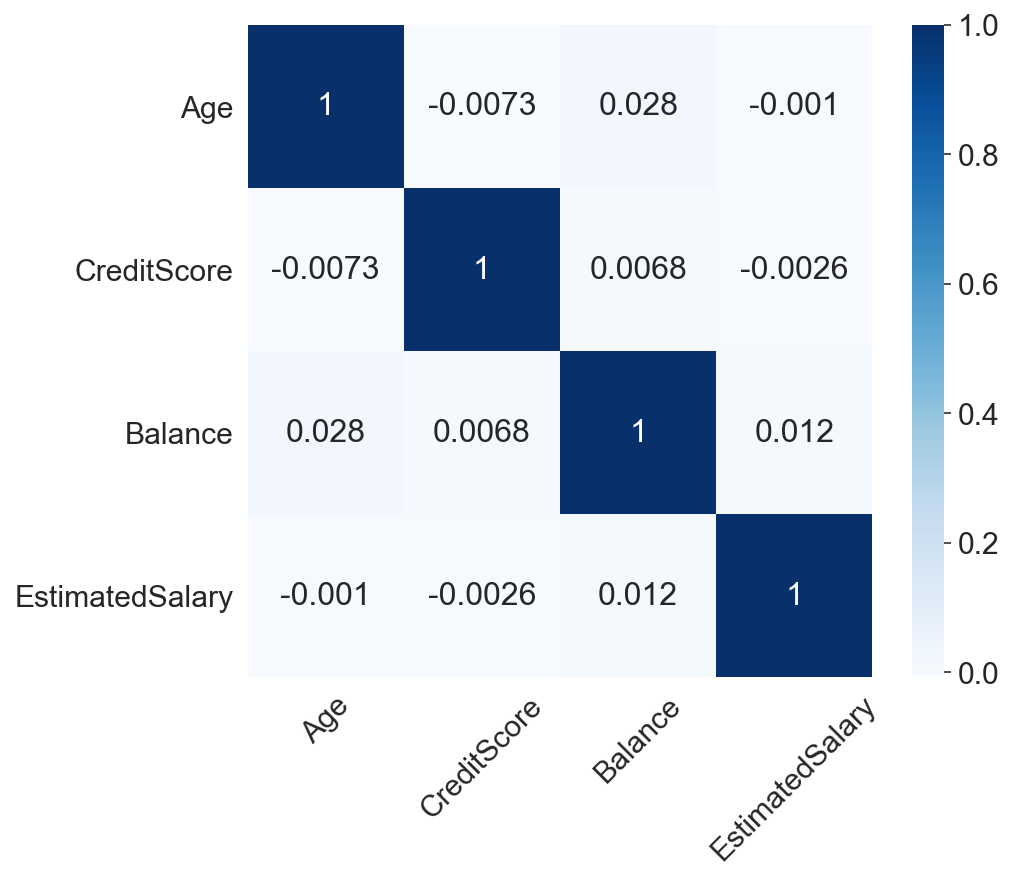

In [10]:
plt.figure(figsize = (7, 6))
ax = sns.heatmap(train_df[continuous].corr(), annot = True, annot_kws = {'fontsize': 16}, cmap = 'Blues')

ax.tick_params(axis = 'x', rotation = 45)
ax.tick_params(axis = 'y', rotation = 360);

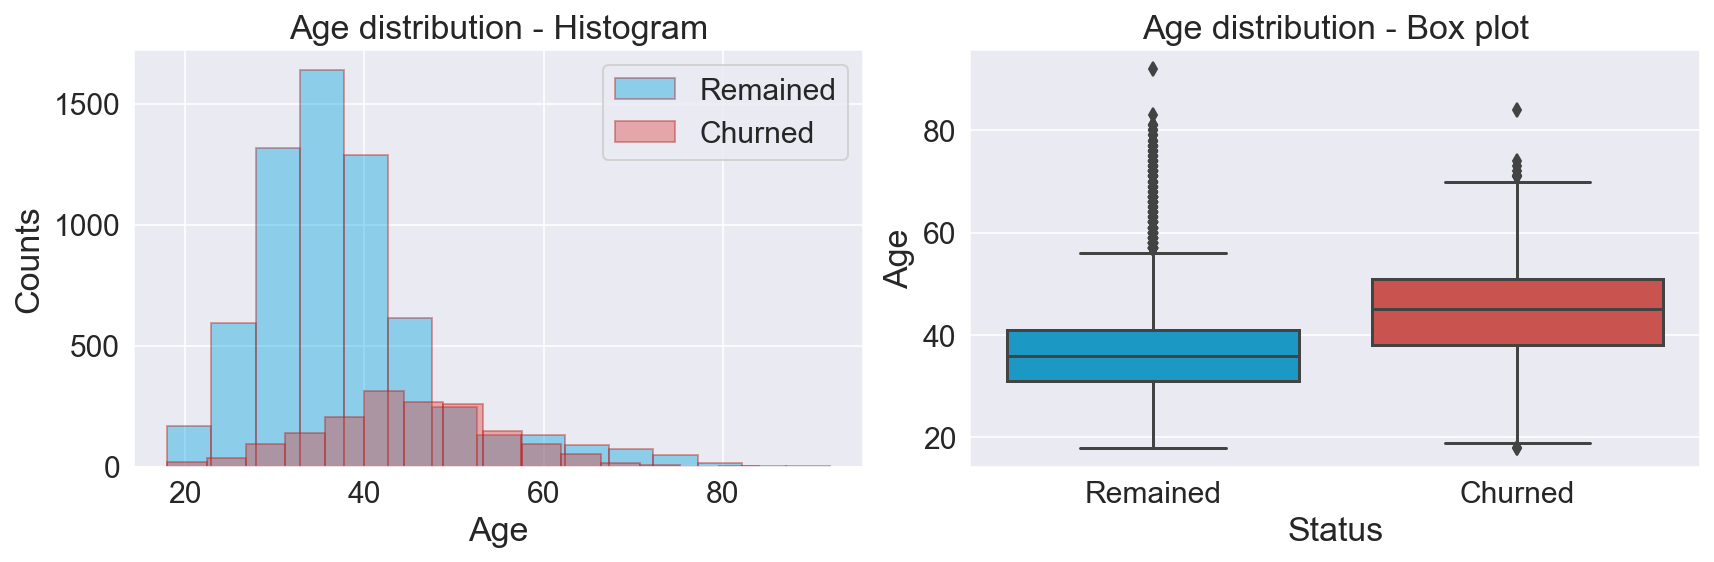

In [11]:
df_churned = train_df[train_df['Exited'] == 1]
df_remained = train_df[train_df['Exited'] == 0]

plot_continuous('Age')

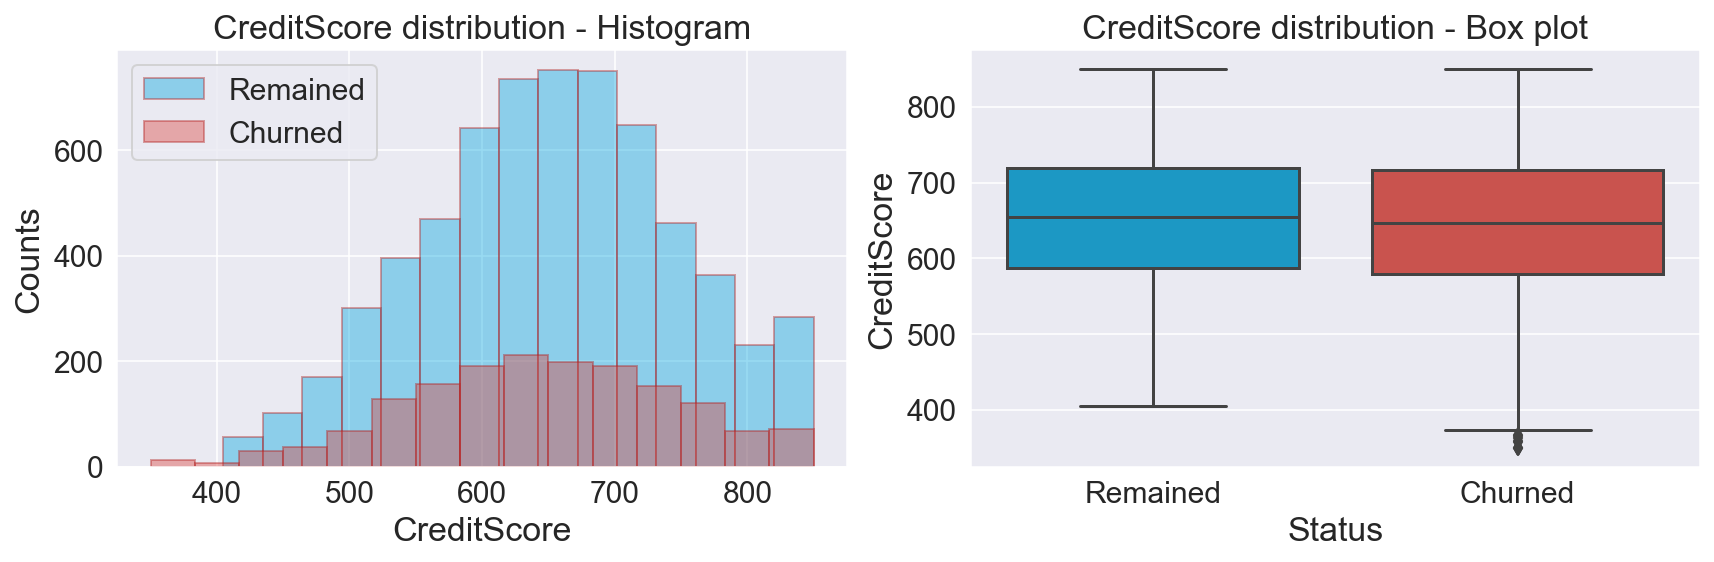

In [12]:
plot_continuous('CreditScore')

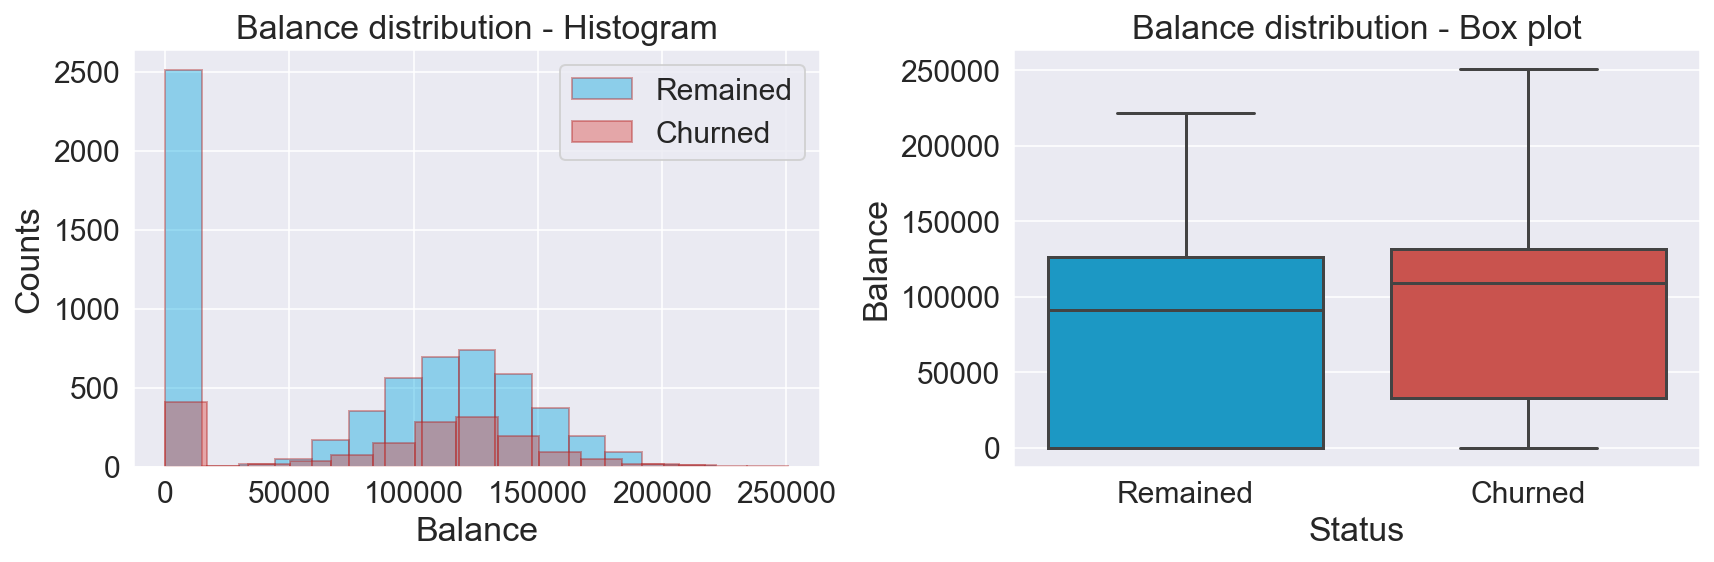

In [13]:
plot_continuous('Balance')

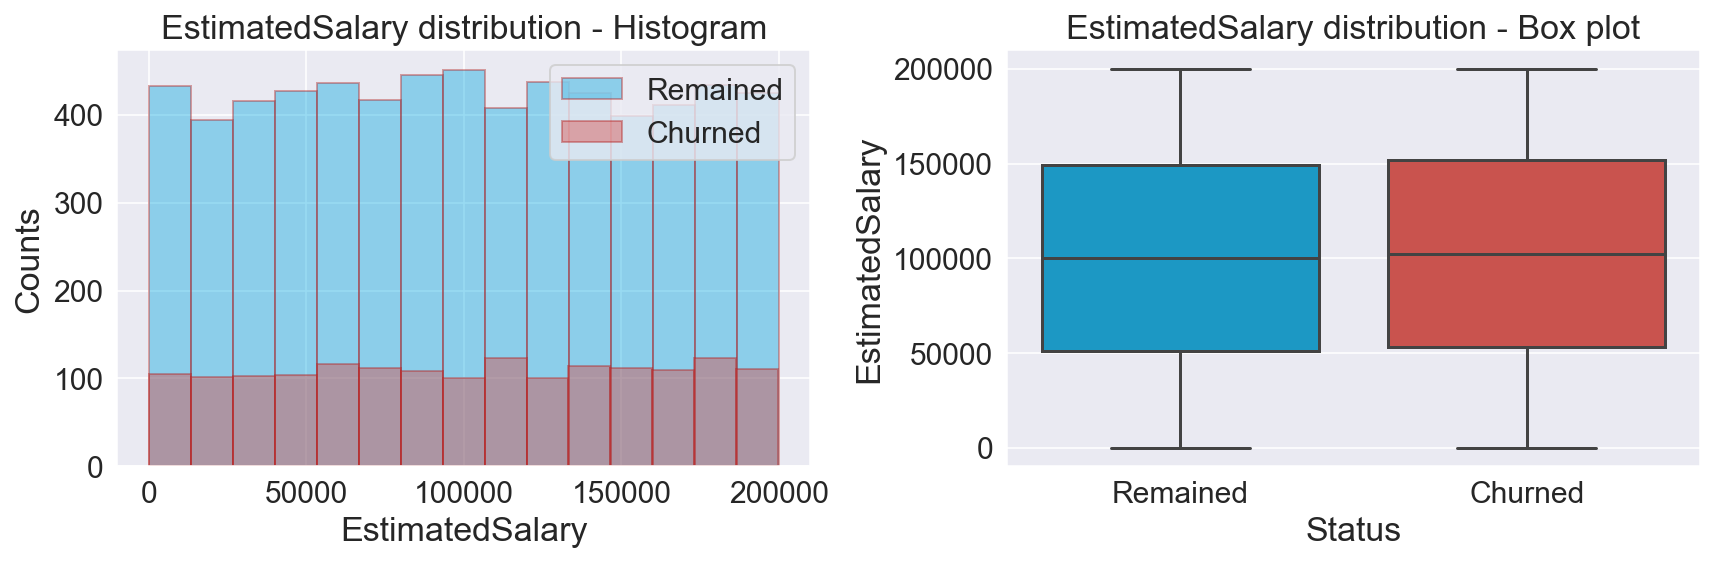

In [14]:
plot_continuous('EstimatedSalary')

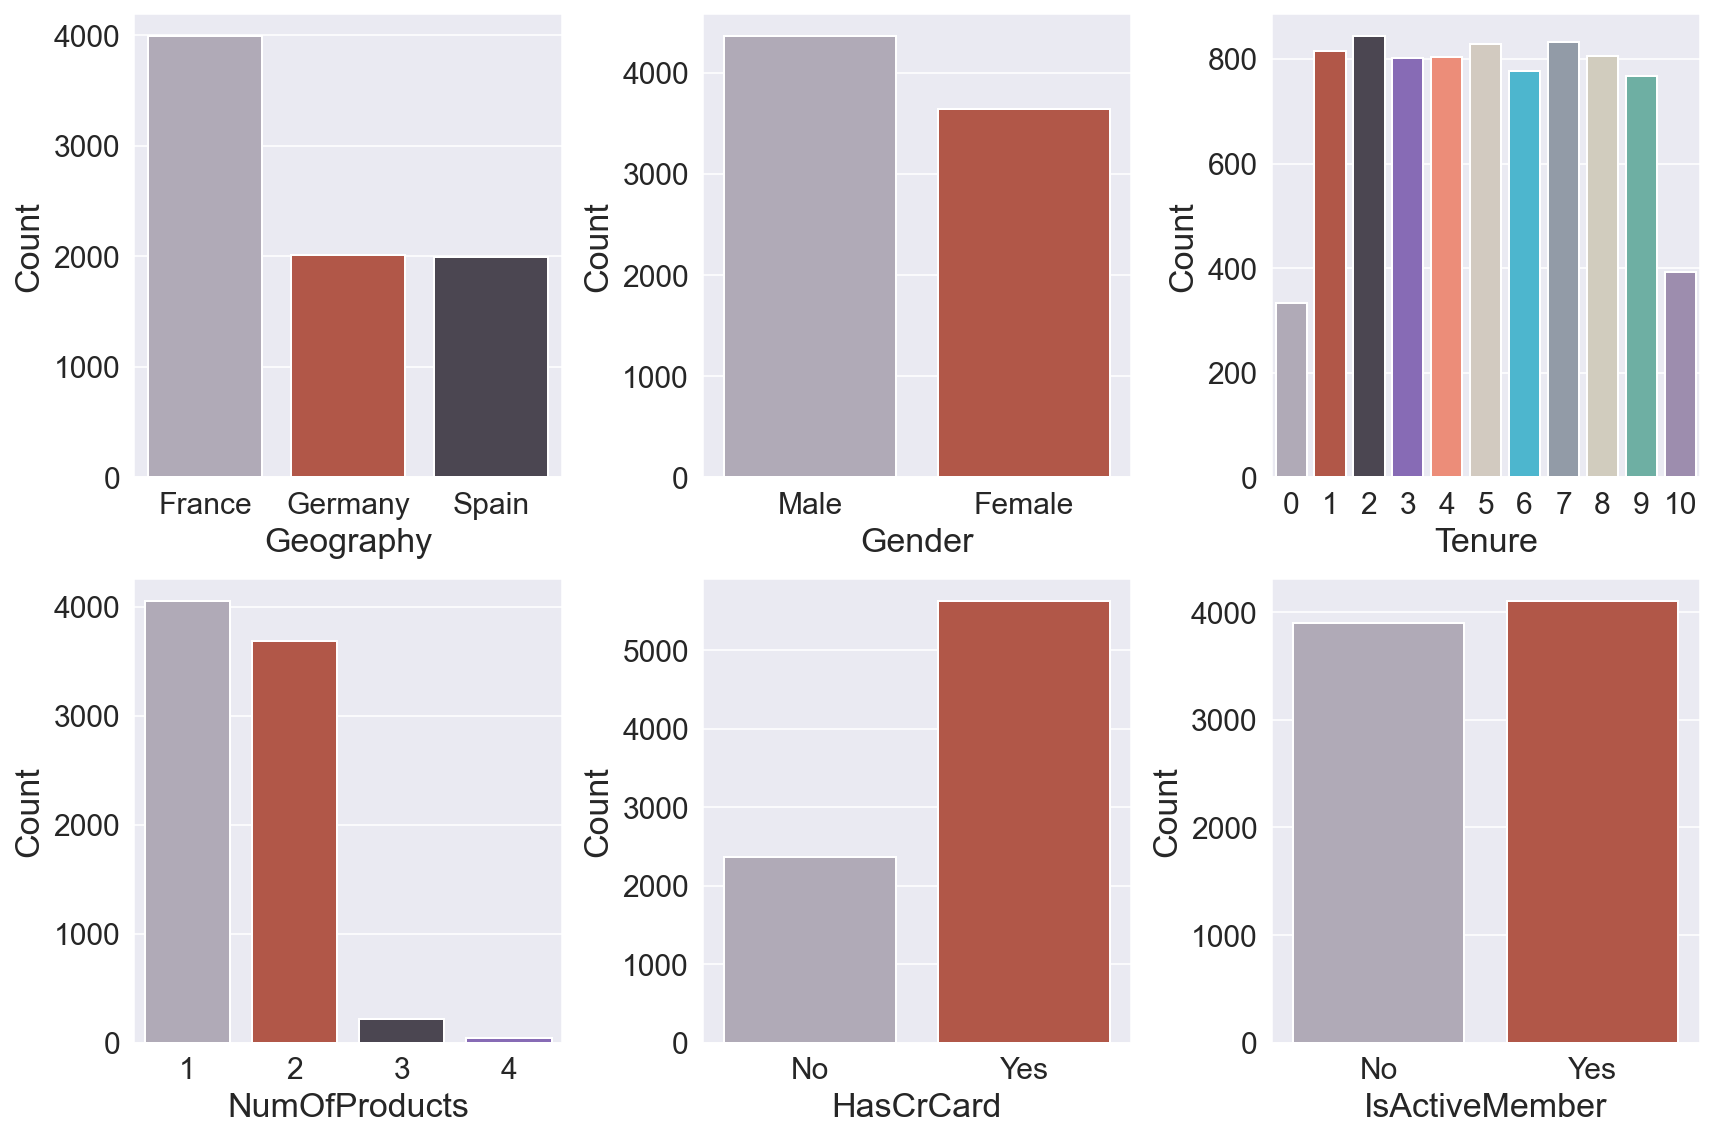

In [15]:
colors2 = ['#B0A8B9', '#C34A36', '#4B4453', '#845EC2', '#FF8066', '#D5CABD', '#38c4e3', '#8f9aaa', '#d4cebb',  '#63BAAA', '#9D88B3']

cat_vars = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
df_cat = train_df[cat_vars]

fig, ax = plt.subplots(2, 3, figsize = (12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x = column, data = train_df, palette = colors2)
    
    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'): 
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout();

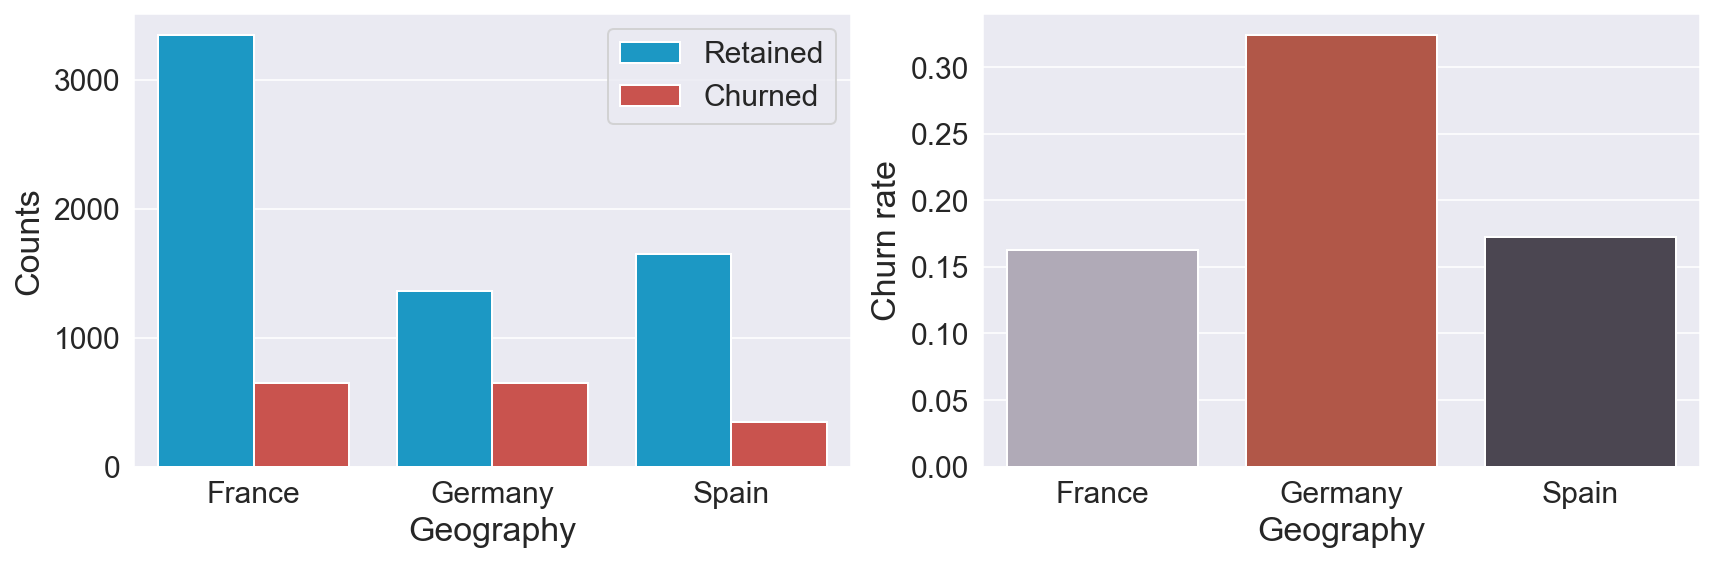

In [16]:
plot_categorical('Geography')

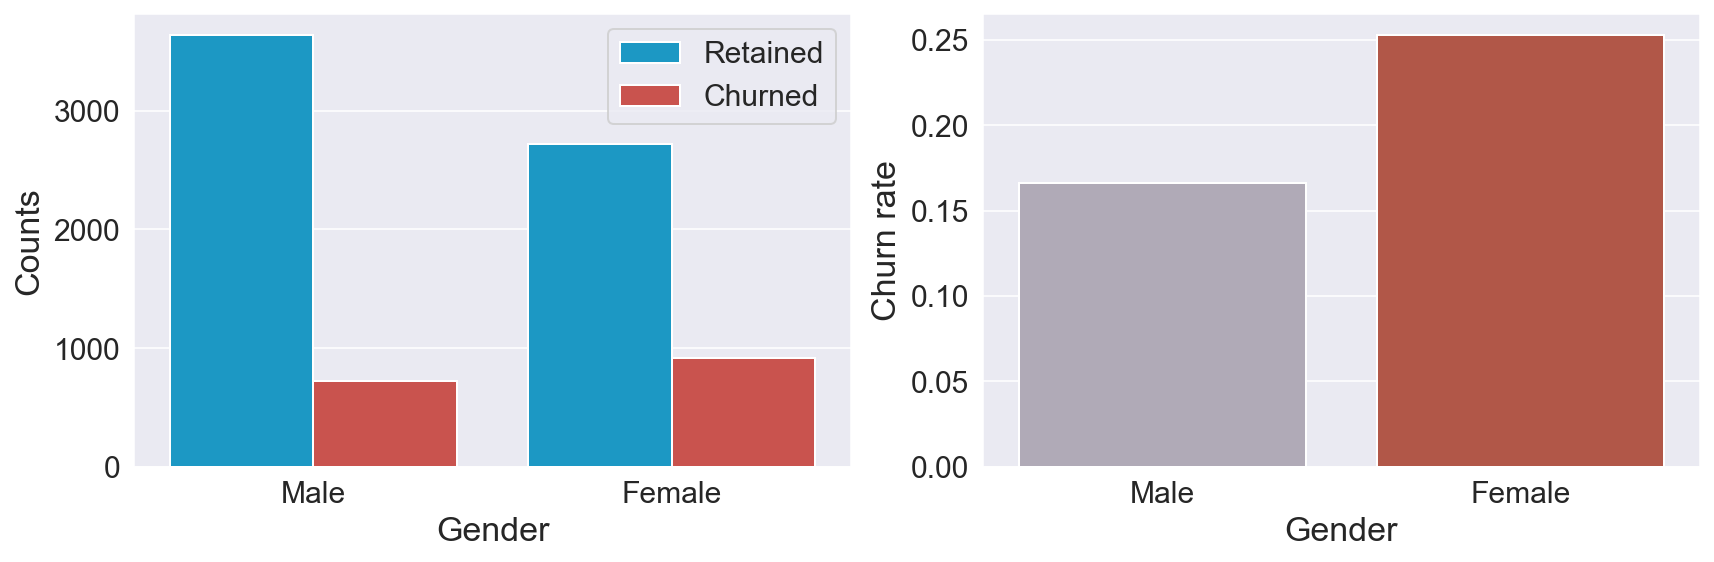

In [17]:
plot_categorical('Gender')

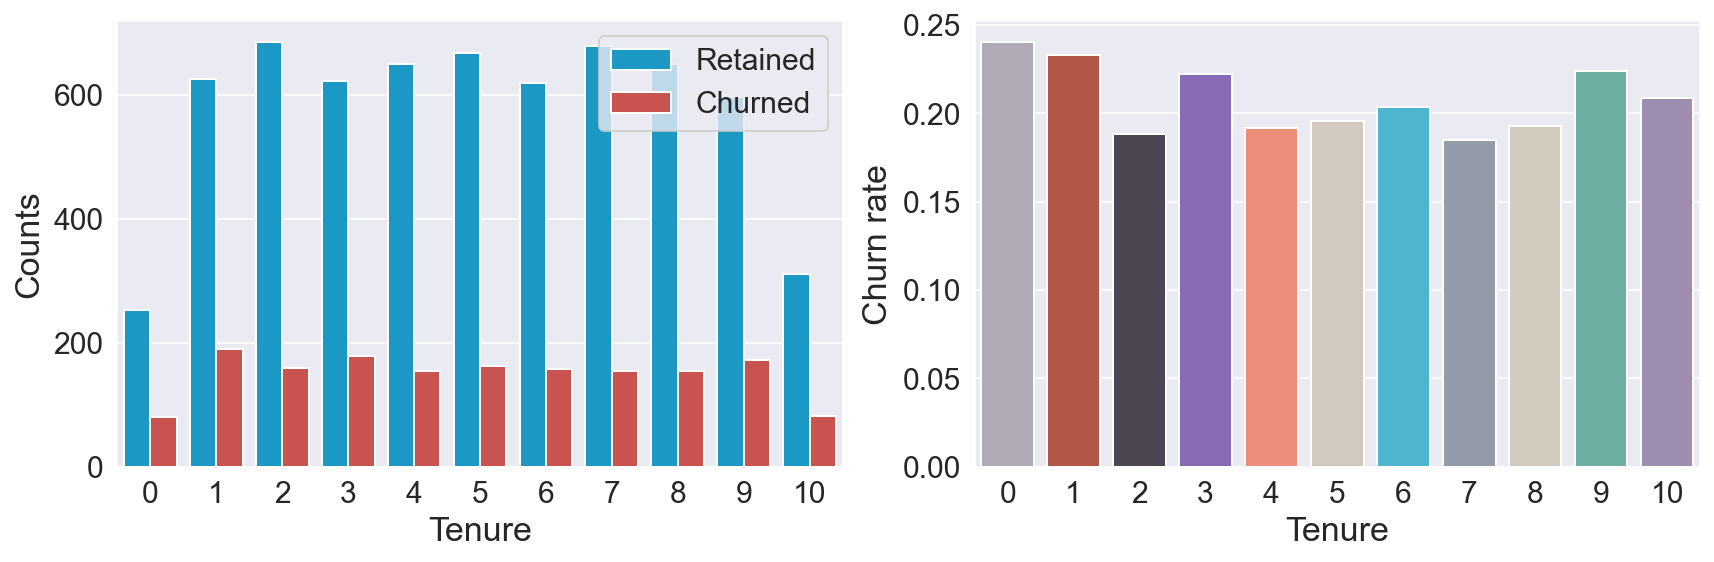

In [18]:
plot_categorical('Tenure')

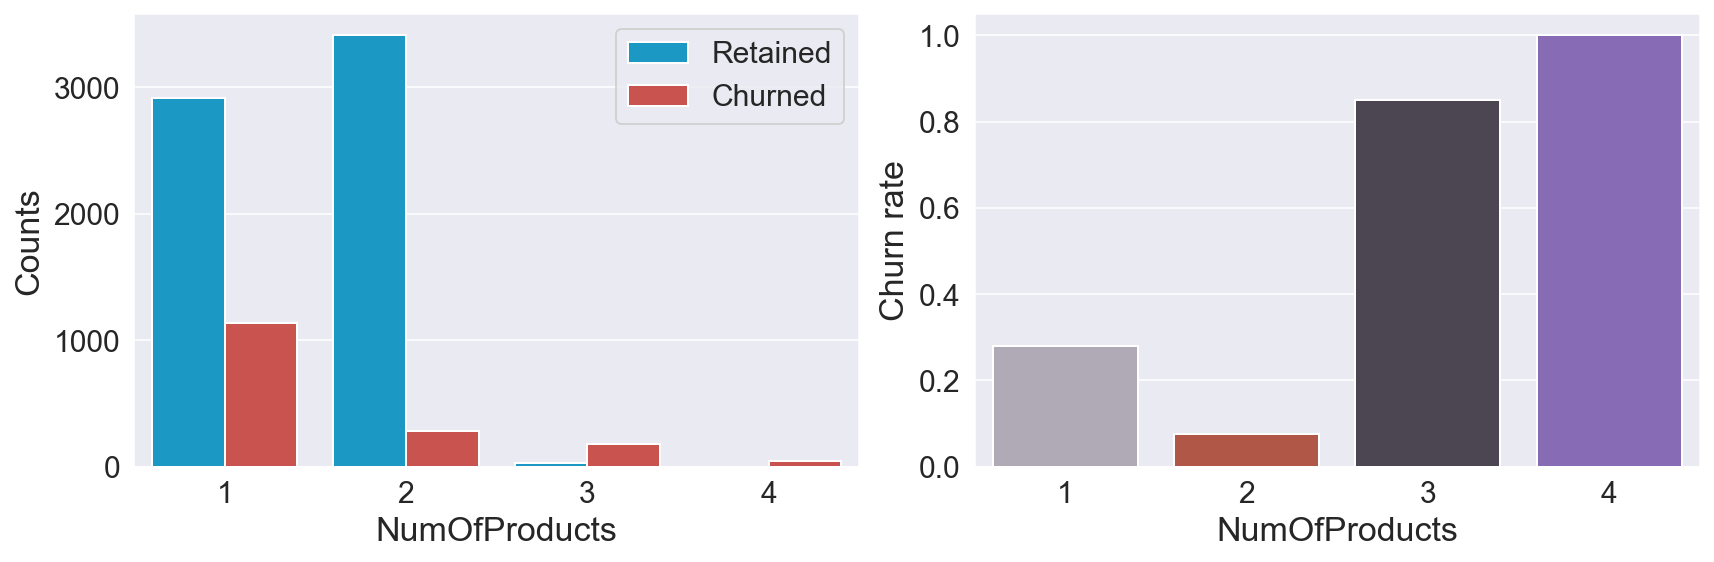

In [19]:
plot_categorical('NumOfProducts')

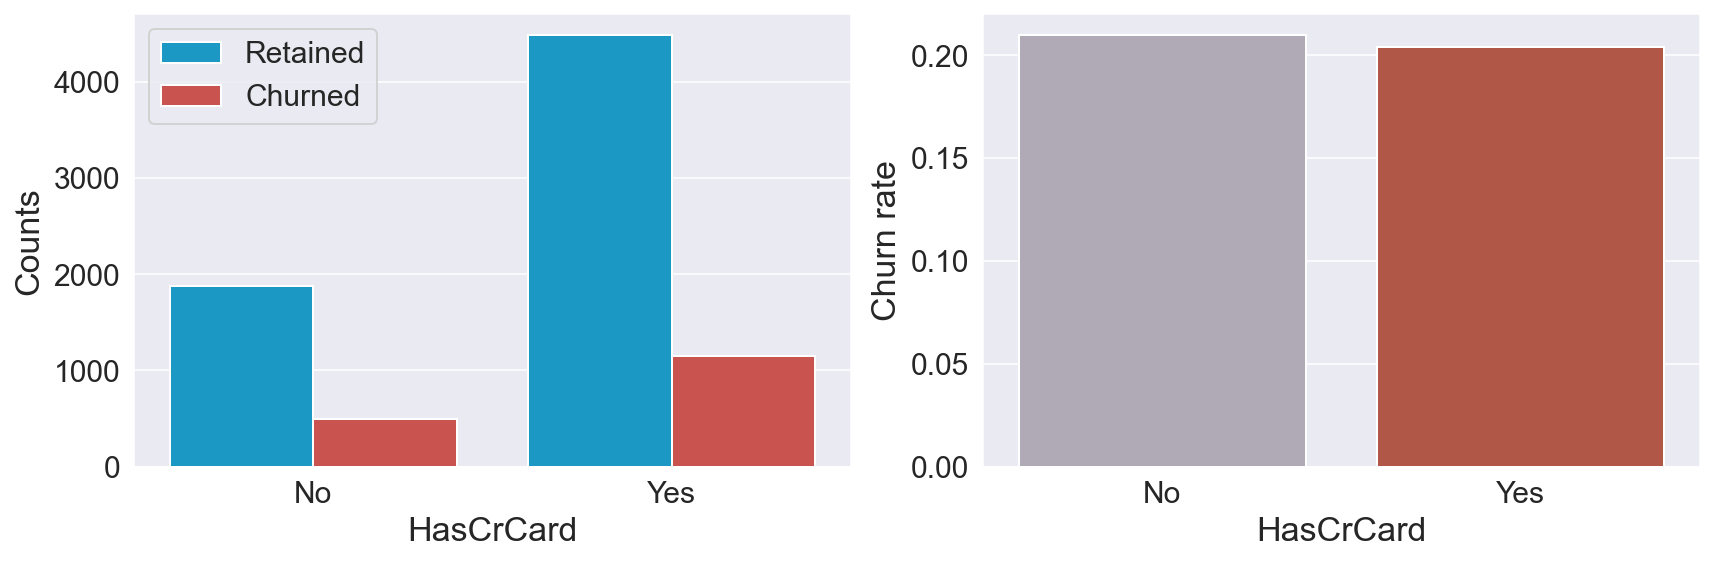

In [20]:
plot_categorical('HasCrCard')

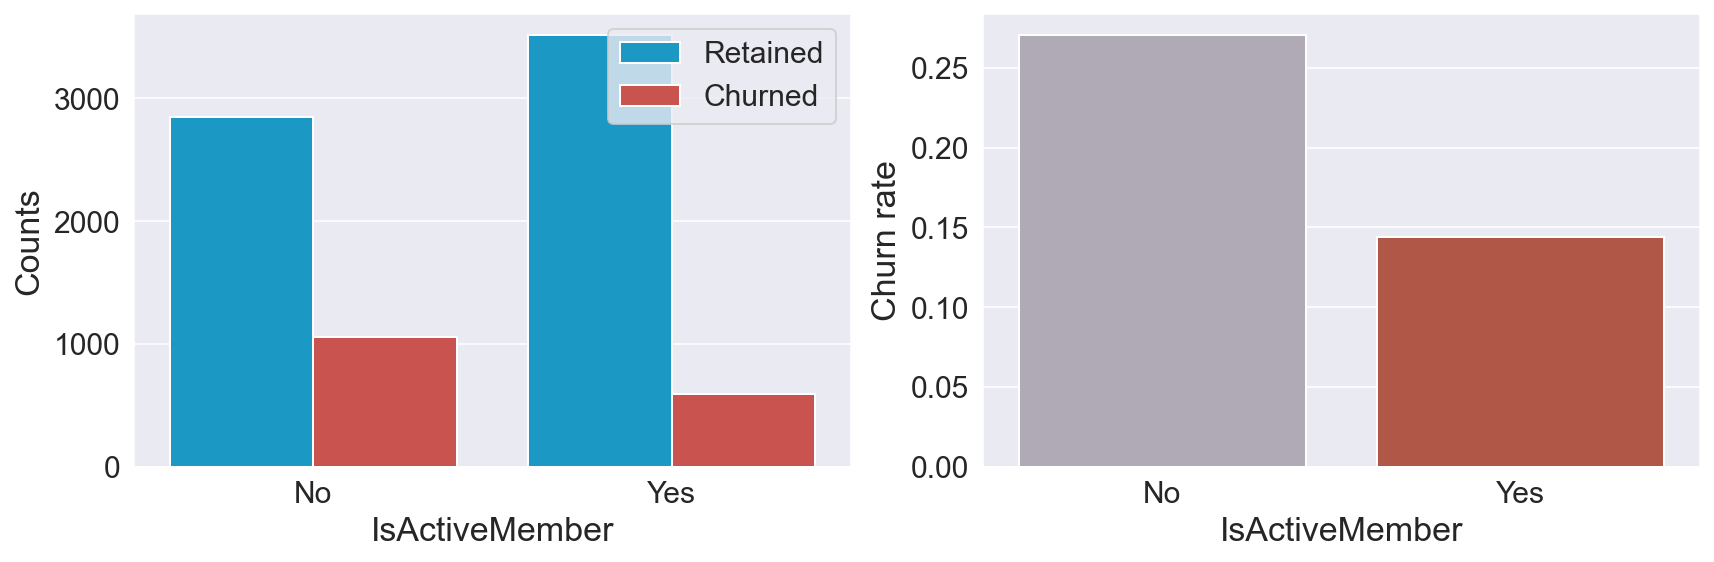

In [21]:
plot_categorical('IsActiveMember')

In [22]:
chi2_array, p_array = [], []
for column in cat_vars:
    
    crosstab = pd.crosstab(train_df[column], train_df['Exited'])
    chi2, p, dof, expected = chi2_contingency(crosstab)
    chi2_array.append(chi2)
    p_array.append(p)

df_chi = pd.DataFrame({'Variable': cat_vars, 
                       'Chi-square': chi2_array, 
                       'p-value': p_array})
df_chi.sort_values(by = 'Chi-square', ascending = False)

,Variable,Chi-square,p-value
3,NumOfProducts,1233.595,3.767e-267
0,Geography,230.748,7.829e-51
5,IsActiveMember,195.315,2.199e-44
1,Gender,90.173,2.183e-21
2,Tenure,15.197,1.250e-01
4,HasCrCard,0.301,5.833e-01


In [23]:
features_drop = ['Tenure', 'HasCrCard', 'EstimatedSalary']
train_df.drop(features_drop, axis = 1, inplace = True) 

print ('Features dropped!')

Features dropped!


In [24]:
train_df['Gender'] = LabelEncoder().fit_transform(train_df['Gender'])

train_df['Geography'] = train_df['Geography'].map({'Germany': 1, 'Spain': 0, 'France': 0})

print ('Features encoded!')

Features encoded!


In [25]:
scaler = StandardScaler()

scl_columns = ['CreditScore', 'Age', 'Balance']
train_df[scl_columns] = scaler.fit_transform(train_df[scl_columns])

print ('Features scaled!')

Features scaled!


In [26]:
y_train = train_df['Exited']
X_train = train_df.drop('Exited', 1)

print ('Sets created!')

Sets created!


In [27]:
before_sm = Counter(y_train)
print(before_sm)

Counter({0: 6356, 1: 1644})


In [28]:
over = SMOTE(sampling_strategy = 'auto', random_state = 42)
X_train, y_train = over.fit_resample(X_train, y_train)

after_sm = Counter(y_train)
print(after_sm)

Counter({0: 6356, 1: 6356})



 Logistic Regression
-------------------------------
   Best Score (recall): 0.73
   Best Parameters: 
      C: 0.001
      max_iter: 100
      penalty: l1
      solver: liblinear


C:\Users\se7en\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_search.py:922: UserWarning: One or more of the test scores are non-finite: [       nan 0.73033268 0.68832581 0.66629851        nan 0.67621085
 0.69257493 0.68549439        nan 0.69005822 0.69163228 0.68958664
        nan 0.69178951 0.69178951 0.69178951        nan 0.69178951
 0.69178951 0.69178951]
  warnings.warn(


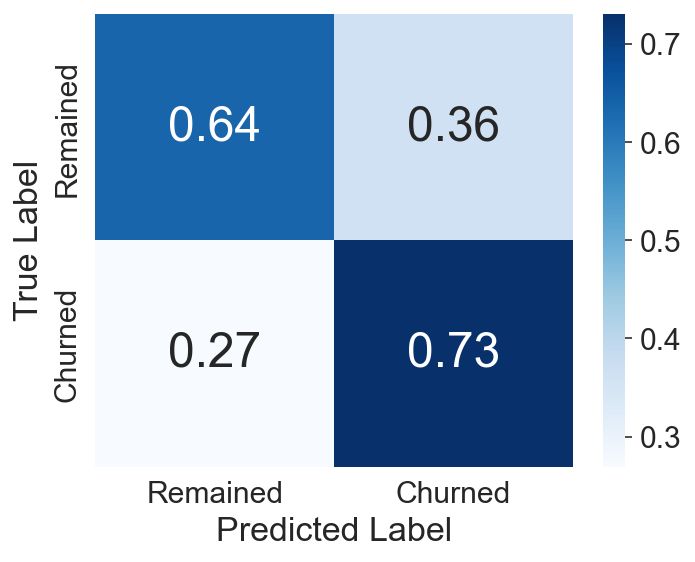

In [29]:
lr = LogisticRegression(random_state = random_state)

param_grid = {'max_iter' : [100],
              'penalty' : ['l1', 'l2'],
              'C' : [0.001, 0.01, 0.1, 1, 10],
              'solver' : ['lbfgs', 'liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, scoring = scoring_metric, 
                      cv = 5, verbose = False, n_jobs = -1)

best_clf_lr = clf_lr.fit(X_train, y_train)
clf_performance(best_clf_lr, 'Logistic Regression', 'LR')


 Support Vector Classifier
-------------------------------
   Best Score (recall): 0.78
   Best Parameters: 
      C: 2
      gamma: scale
      kernel: rbf


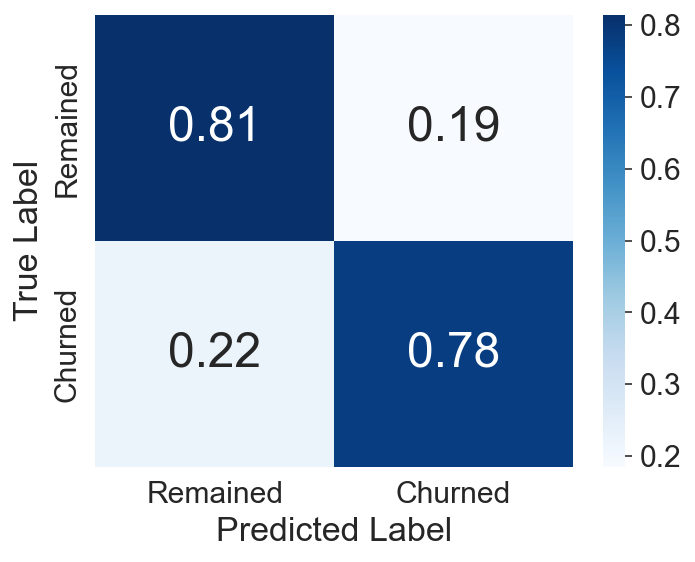

In [30]:
svc = SVC(probability = True, random_state = random_state)
param_grid = tuned_parameters = [{'kernel': ['rbf'],
                                  'gamma': ['scale', 'auto'],
                                  'C': [.1, 1, 2]},
                                 {'kernel': ['linear'], 
                                  'C': [.1, 1, 10]}]

clf_svc = GridSearchCV(svc, param_grid = param_grid, scoring = scoring_metric, cv = 5, verbose = False, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train, y_train)
clf_performance(best_clf_svc, 'Support Vector Classifier', 'SVC')


 Random Forest Classifier
-------------------------------
   Best Score (recall): 0.772
   Best Parameters: 
      bootstrap: True
      criterion: gini
      max_depth: 6
      max_features: auto
      min_samples_leaf: 3
      min_samples_split: 2
      n_estimators: 50


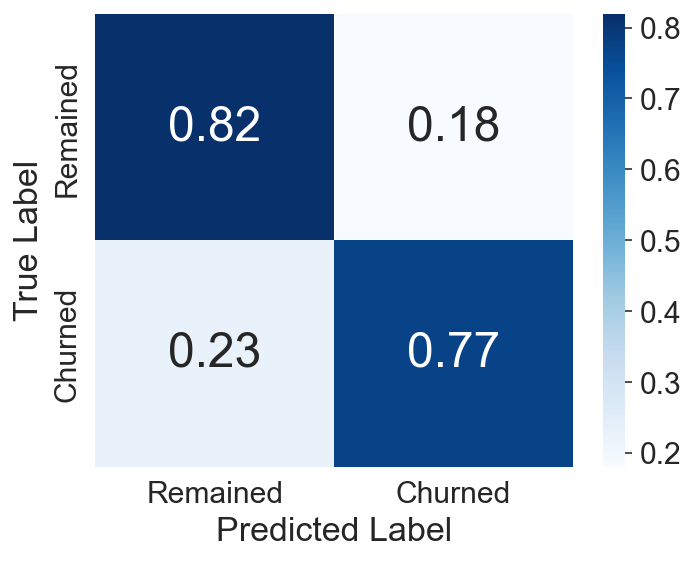

In [31]:
rf = RandomForestClassifier(random_state = random_state)
param_grid = {'n_estimators': [50],
              'criterion': ['entropy', 'gini'],
              'bootstrap': [True],
              'max_depth': [6],
              'max_features': ['auto','sqrt'],
              'min_samples_leaf': [2, 3, 5],
              'min_samples_split': [2, 3, 5]}
                                  
clf_rf = GridSearchCV(rf, param_grid = param_grid, scoring = scoring_metric, cv = 5, verbose = False, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train, y_train)
clf_performance(best_clf_rf, 'Random Forest Classifier', 'RF')


 Gradient Boosting Classifier
-------------------------------
   Best Score (recall): 0.755
   Best Parameters: 
      learning_rate: 0.01
      max_depth: 3
      max_features: auto
      min_samples_leaf: 3
      min_samples_split: 5
      n_estimators: 600
      n_iter_no_change: 20
      subsample: 0.66
      tol: 0.01
      validation_fraction: 0.2


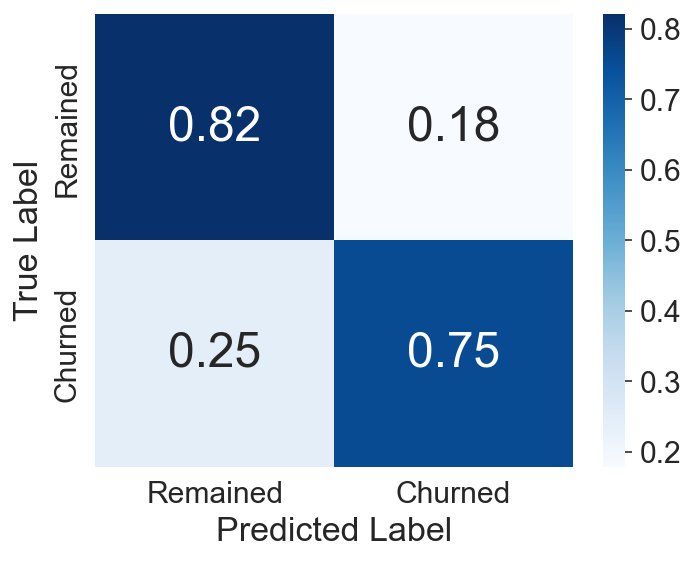

In [32]:
gbc = GradientBoostingClassifier(random_state = random_state)
param_grid = {'n_estimators': [600],
              'subsample': [0.66, 0.75],
              'learning_rate': [0.001, 0.01],
              'max_depth': [3],                       # default=3
              'min_samples_split': [5, 7],
              'min_samples_leaf': [3, 5],
              'max_features': ['auto', 'log2', None],
              'n_iter_no_change': [20],
              'validation_fraction': [0.2],
              'tol': [0.01]}
                                  
clf_gbc = GridSearchCV(gbc, param_grid = param_grid, scoring = scoring_metric, cv = 5, verbose = False, n_jobs = -1)
best_clf_gbc = clf_gbc.fit(X_train, y_train)
clf_performance(best_clf_gbc, 'Gradient Boosting Classifier', 'GBC')

In [33]:
best_clf_gbc.best_estimator_.n_estimators_

284

C:\Users\se7en\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\se7en\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.785
   Best Parameters: 
      colsample_bytree: 0.5
      gamma: 1
      learning_rate: 0.001
      max_depth: 4
      min_child_weight: 1
      n_estimators: 50
      reg_alpha: 1
      reg_lambda: 1
      subsample: 0.75
[13:43:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\se7en\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\se7en\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\se7en\AppData\Roaming\Python\Python39\site-pack

[13:43:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\se7en\AppData\Roaming\Python\Python39\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


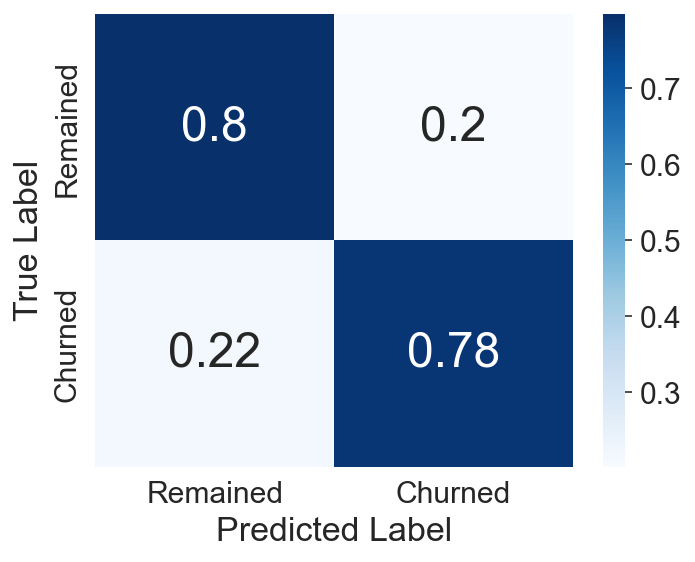

In [34]:
xgb = XGBClassifier(random_state = random_state)

param_grid = {'n_estimators': [50],
              'learning_rate': [0.001, 0.01],
              'max_depth': [3, 4],                # default=6
              'reg_alpha': [1, 2],
              'reg_lambda': [1, 2],
              'subsample': [0.5, 0.75],
              'colsample_bytree': [0.50, 0.75],
              'gamma': [0.1, 0.5, 1],
              'min_child_weight': [1]}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, scoring = scoring_metric, cv = 5, verbose = False, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train, y_train)
clf_performance(best_clf_xgb, 'XGBoost Classifier', 'XGBC')

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5

 LGBMClassifier
-------------------------------
   Best Score (recall): 0.779
   Best Parameters: 
      feature_fraction: 0.5
      learning_rate: 0.01
      max_depth: 5
      min_child_samples: 10
      n_estimators: 200
      num_leaves: 10
      reg_alpha: 0.1
      reg_lambda: 0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5


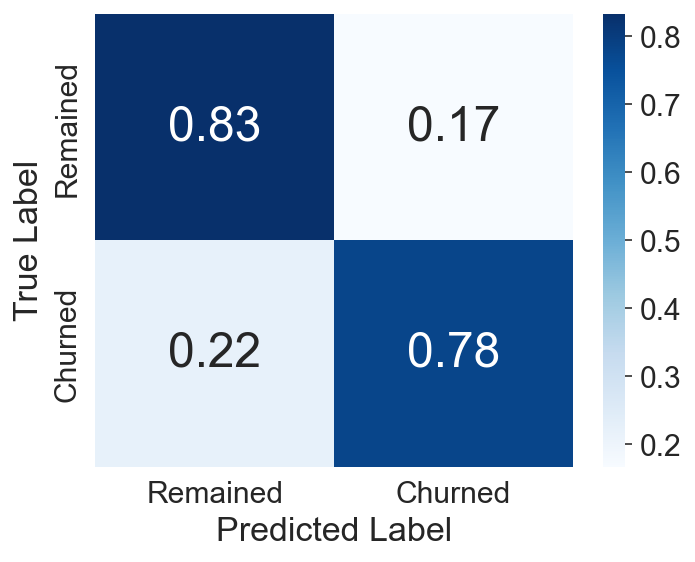

In [35]:
lgbmc = LGBMClassifier(random_state = random_state)

param_grid = {'max_depth': [5],
              'num_leaves': [5, 10],
              'learning_rate': [0.001, 0.01],
              'n_estimators': [200],
              'feature_fraction': [0.5],
              'min_child_samples': [5, 10],
              'reg_alpha': [0.1, 0.5],
              'reg_lambda': [0.1, 0.5]} 

clf_lgbmc = GridSearchCV(lgbmc, param_grid = param_grid, verbose = False,
                         scoring = scoring_metric, cv = 5, n_jobs = -1)

best_clf_lgbmc = clf_lgbmc.fit(X_train, y_train)
clf_performance(best_clf_lgbmc, 'LGBMClassifier', 'LGBMC')

Soft Voting
-----------------
  Recall:  0.785


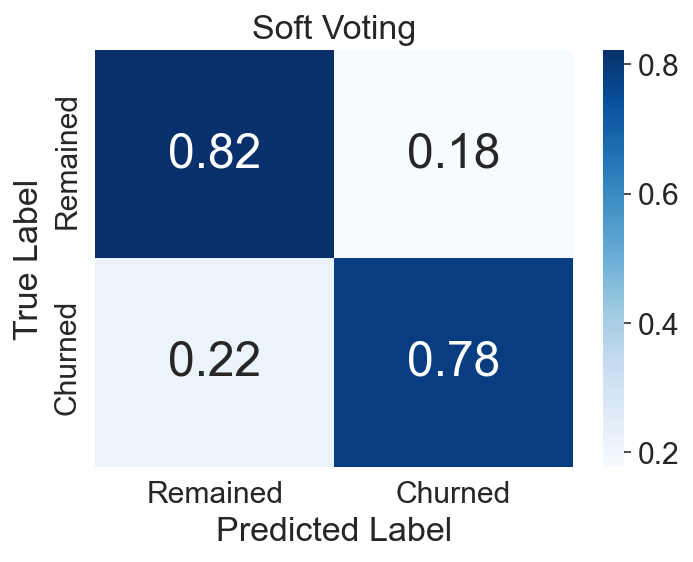

In [36]:
estimators = [('LR', best_clf_lr.best_estimator_),
              ('SCV', best_clf_svc.best_estimator_),
              ('RF', best_clf_rf.best_estimator_),
              ('GBC', best_clf_gbc.best_estimator_),
              ('XGB', best_clf_xgb.best_estimator_),
              ('LGBMC', best_clf_lgbmc.best_estimator_)]

tuned_voting_soft = VotingClassifier(estimators = estimators[1:], voting = 'soft', n_jobs = -1)
estimators.append(('SoftV', tuned_voting_soft))

y_pred_pp = cross_val_predict(tuned_voting_soft, X_train, y_train, cv = 5, method = 'predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize = 'true')
fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
comparison_dict['SVot'] = [accuracy_score(y_train, y_pred),
                           precision_score(y_train, y_pred),
                           recall_score(y_train, y_pred),
                           roc_auc_score(y_train, y_pred_pp), fpr, tpr]

print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

fig, ax = plt.subplots(figsize = (5, 4))

plot_conf_mx(cm, 'Soft Voting', ax)    
plt.tight_layout();

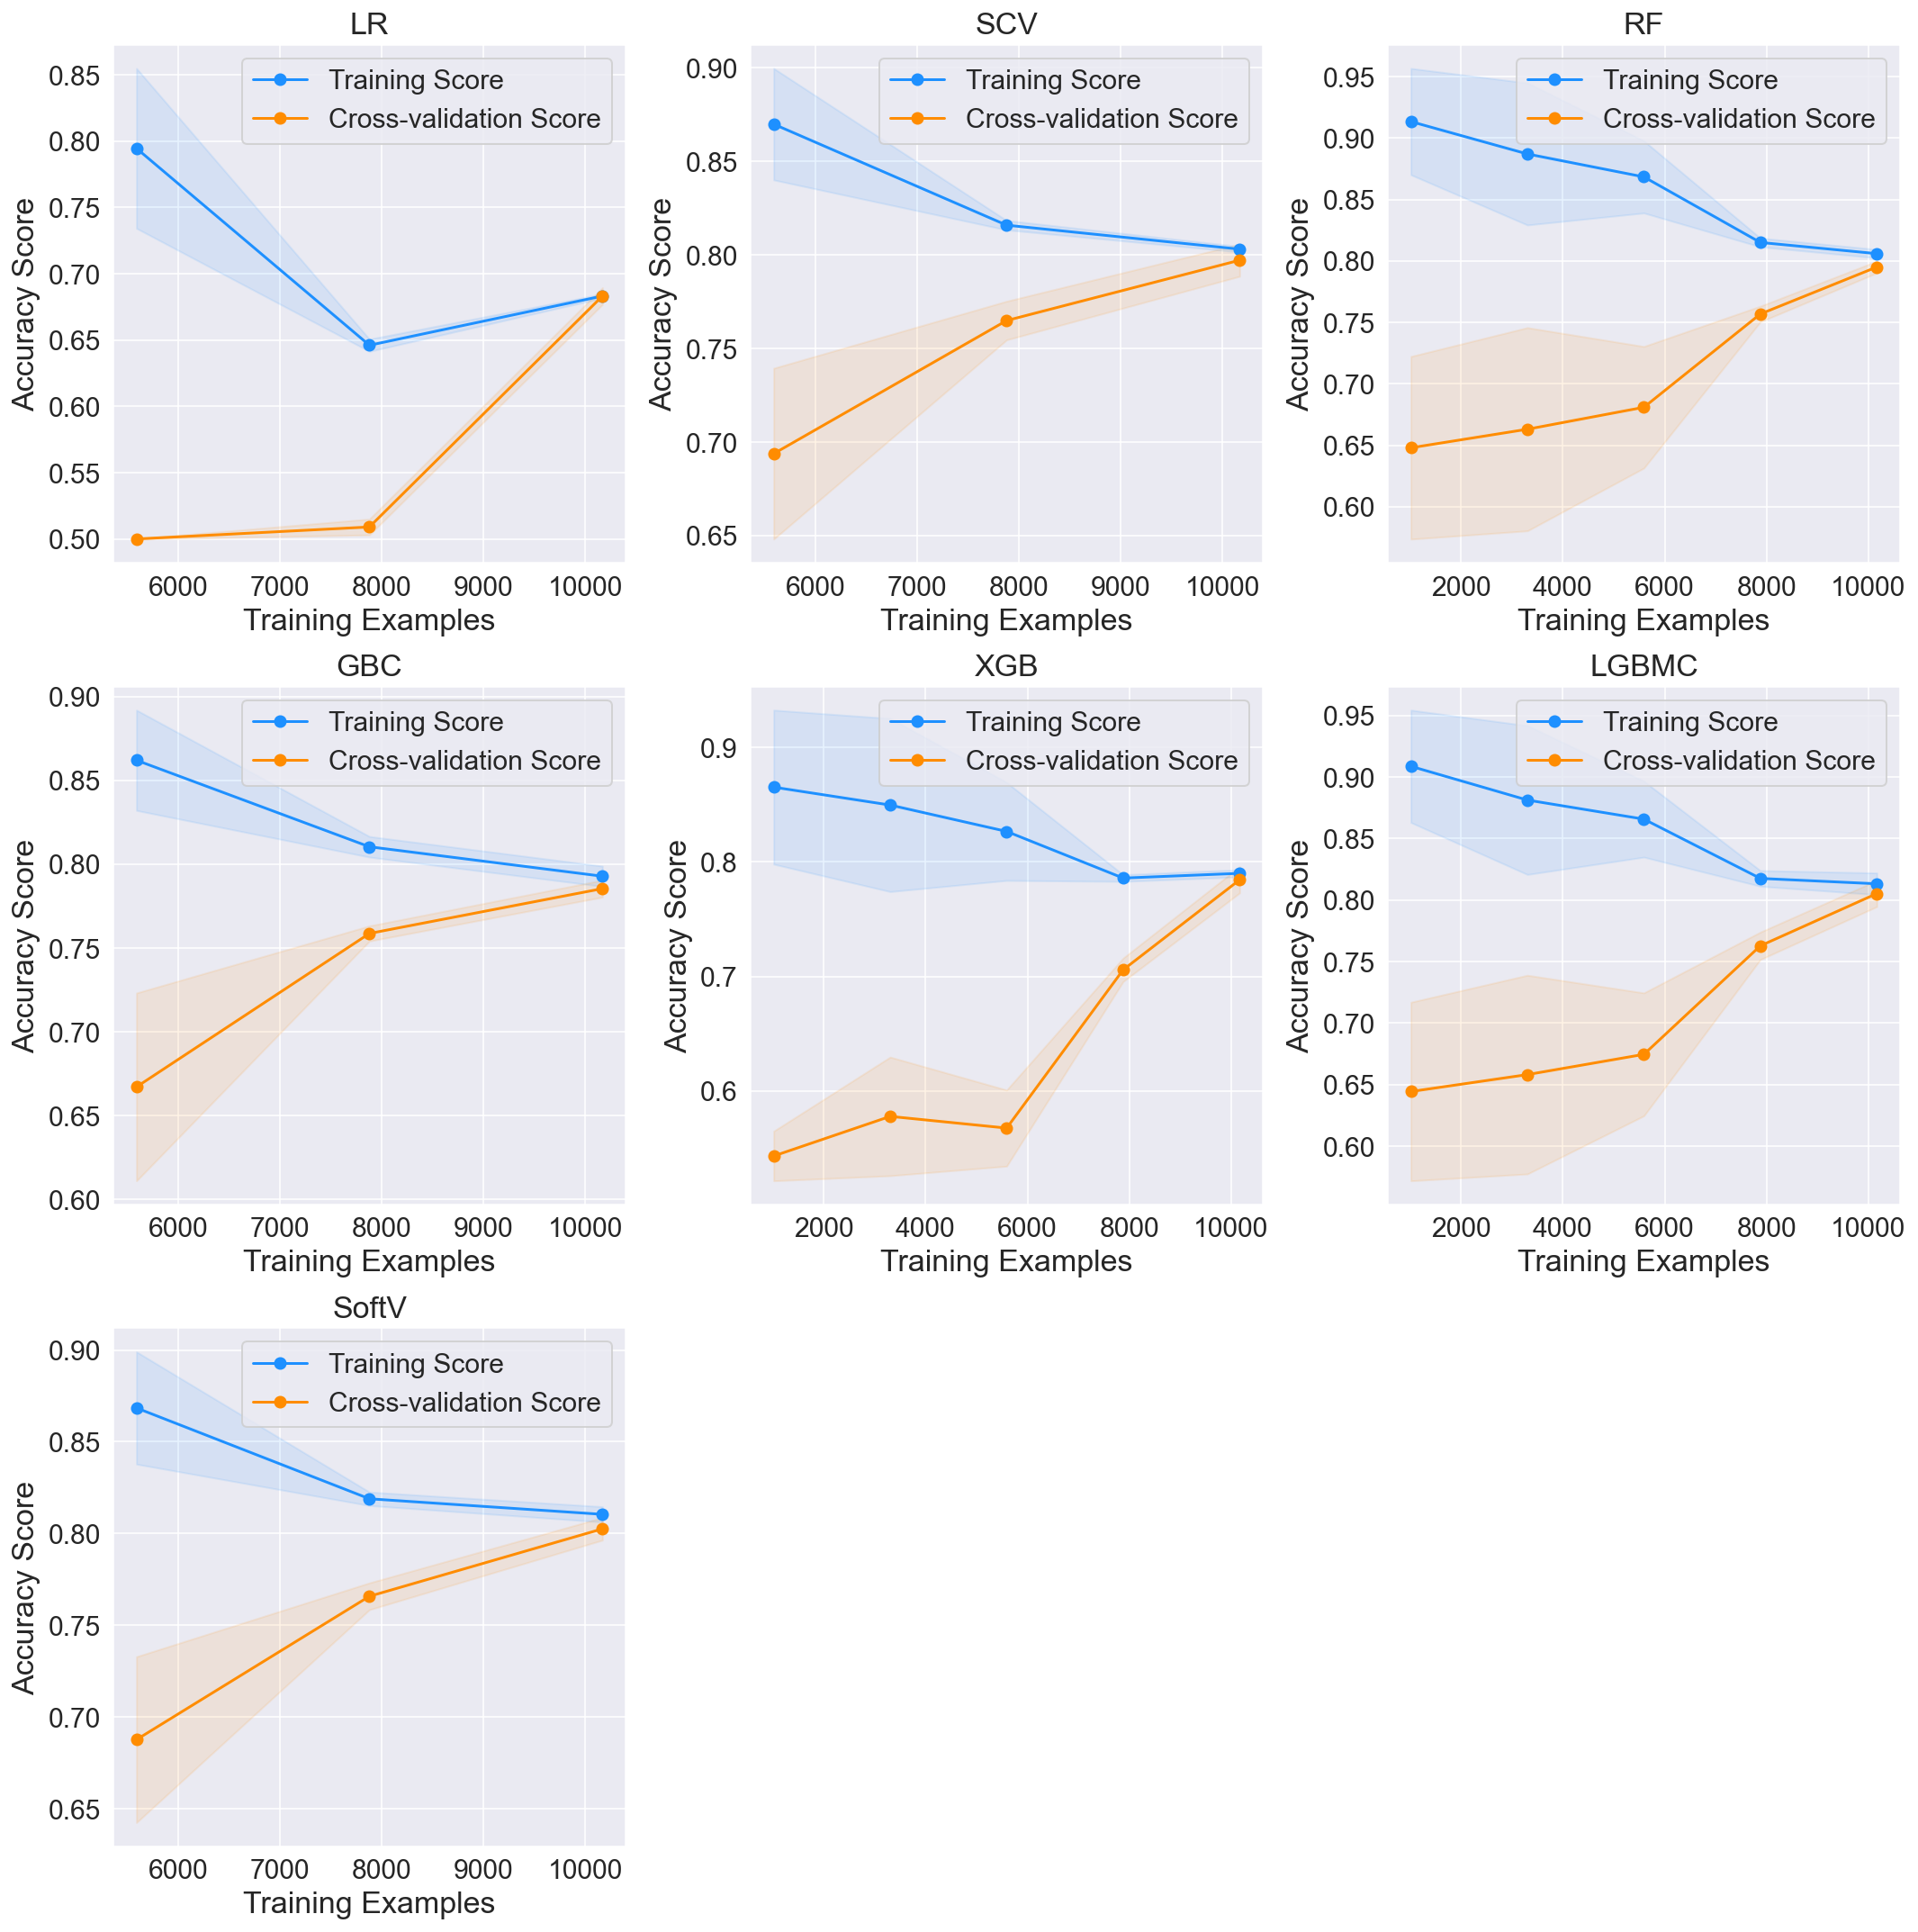

In [37]:
fig, ax = plt.subplots(3, 3, figsize = (15, 15))

for i in range(len(estimators)):
    plt.subplot(3, 3, i + 1)
    plot_learning_curve(estimators[i][1], estimators[i][0], X_train, y_train)
    
plt.tight_layout()
ax[2,1].set_axis_off()
ax[2,2].set_axis_off();

## Send us the Result (Maktabkhoone)